In [64]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd

In [65]:
# Step 2: Define function to load from a GeoTIFF file
def load_tif(filepath):
    """Load a single-band TIFF file as a numpy array."""
    with rasterio.open(filepath) as src:
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        
        return src.read(1), src.transform, src.crs, extent


In [66]:
def scale(tiff_image): 
    return -1 + 2 * (tiff_image - tiff_image.min()) / (tiff_image.max() - tiff_image.min())

In [67]:
def read_kml(ref_tiff_path):
    # Load the KML file
    kml_path = 'dhaka_cIty_gis_project.kml'
    kml_gdf = gpd.read_file(kml_path, driver="KML", allow_unsupported_drivers=True)

    with rasterio.open(ref_tiff_path) as src:
        ref_crs = src.crs

    # Reproject the KML to match the TIFF CRS
    if kml_gdf.crs != ref_crs:
        kml_gdf = kml_gdf.to_crs(ref_crs)

    return kml_gdf

In [68]:
# Function to calculate NDVI
def calculate_ndvi(nir, red):
    return (nir - red) / (nir + red)

# Function to calculate NDBI
def calculate_ndbi(swir, nir):
    return (swir - nir) / (swir + nir)

# Function to calculate MNDWI
def calculate_mndwi(green, swir):
    return (green - swir) / (green + swir)

# Function to calculate IBI
def calculate_ibi(ndbi, ndvi, mndwi):
    return (ndbi - (ndvi + mndwi)) / (ndbi + (ndvi + mndwi))

In [69]:
# Main function for IBI calculation and visualization
def calc_ibi(swir_path, nir_path, red_path, green_path, year, output_path):
    """
    Calculate, visualize, and save the Index-based Built-up Index (IBI).
    
    Parameters:
    - swir_path: Path to the SWIR band (e.g., Band 6 for Landsat 8)
    - nir_path: Path to the NIR band (e.g., Band 5 for Landsat 8)
    - red_path: Path to the Red band (e.g., Band 4 for Landsat 8)
    - green_path: Path to the Green band (e.g., Band 3 for Landsat 8)
    - year: Year for labeling the output visualization
    - output_path: Path to save the calculated IBI
    """
    # Load the required bands
    swir, transform, crs, extent = load_tif(swir_path)
    nir, _, _, _ = load_tif(nir_path)
    red, _, _, _ = load_tif(red_path)
    green, _, _, _ = load_tif(green_path)

    kml_gdf = read_kml(nir_path)

    # normalize band values into [0, 1]

    # Calculate NDBI, NDVI, and MNDWI
    ndbi = calculate_ndbi(swir, nir)
    ndvi = calculate_ndvi(nir, red)
    mndwi = calculate_mndwi(green, swir)

    # Calculate IBI
    ibi = calculate_ibi(ndbi, ndvi, mndwi)
    ibi = scale(ibi)

    ibi = -1*ibi

    # Plot the IBI result
    plt.figure(figsize=(8, 6))
    plt.imshow(ibi, cmap='RdYlGn', vmin=-1, vmax=1, extent=extent)
    plt.colorbar(label="IBI")
    plt.title(f"Index-based Built-up Index (IBI) {year}")
    plt.xlabel("Pixel Column")
    plt.ylabel("Pixel Row")

    # Overlay the KML polygons
    kml_gdf.boundary.plot(ax=plt.gca(), color='black', linewidth=6)

    output_path = output_path + year + "/IBI_" + year
    output_tiff = output_path + ".tif"
    output_png = output_path + ".png"

     # Save NDBI as GeoTIFF
    metadata = {
        'driver': 'GTiff',
        'dtype': 'float32',
        'nodata': None,
        'width': ibi.shape[1],
        'height': ibi.shape[0],
        'count': 1,
        'crs': crs,
        'transform': transform,
    }
    with rasterio.open(output_tiff, 'w', **metadata) as dst:
        dst.write(ibi.astype('float32'), 1)  # Save as first band

    plt.savefig(output_png, dpi=300, bbox_inches='tight')

    plt.show()
    
    print(f"IBI saved to {output_path}")

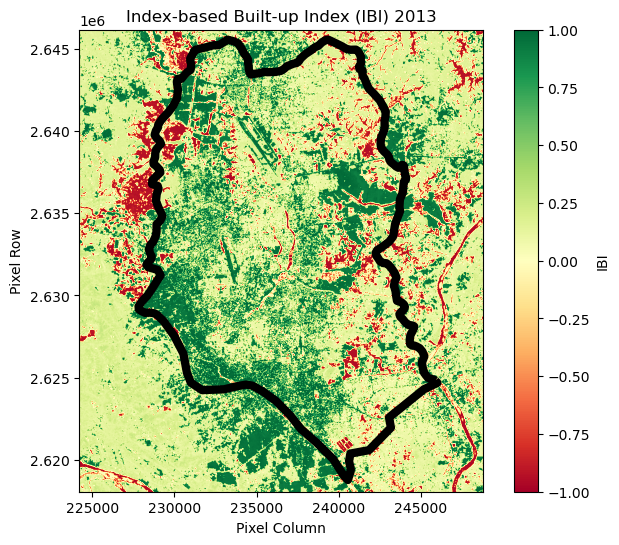

IBI saved to ./Landsat8/output/2013/IBI_2013


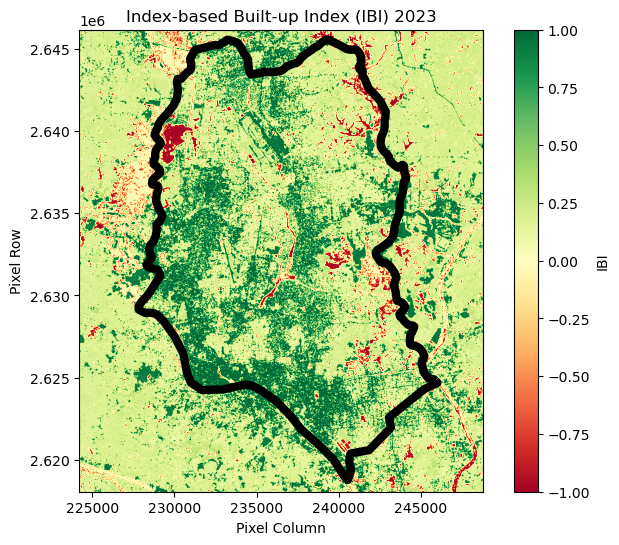

IBI saved to ./Landsat8/output/2023/IBI_2023


In [70]:
# Paths to data
ROOT = './Landsat8/cropped_bbox/'
OUTPUT = "./Landsat8/output/"

# IBI calculation and saving for 2013
swir_path_2013 = ROOT + '2013/LC08_L2SP_137044_20131224_20200912_02_T1_SR_B6.TIF'
nir_path_2013 = ROOT + '2013/LC08_L2SP_137044_20131224_20200912_02_T1_SR_B5.TIF'
red_path_2013 = ROOT + '2013/LC08_L2SP_137044_20131224_20200912_02_T1_SR_B4.TIF'
green_path_2013 = ROOT + '2013/LC08_L2SP_137044_20131224_20200912_02_T1_SR_B3.TIF'

calc_ibi(swir_path_2013, nir_path_2013, red_path_2013, green_path_2013, '2013', OUTPUT)

# IBI calculation and saving for 2023
swir_path_2023 = ROOT + '2023/LC08_L2SP_137044_20231102_20231109_02_T1_SR_B6.TIF'
nir_path_2023 = ROOT + '2023/LC08_L2SP_137044_20231102_20231109_02_T1_SR_B5.TIF'
red_path_2023 = ROOT + '2023/LC08_L2SP_137044_20231102_20231109_02_T1_SR_B4.TIF'
green_path_2023 = ROOT + '2023/LC08_L2SP_137044_20231102_20231109_02_T1_SR_B3.TIF'

calc_ibi(swir_path_2023, nir_path_2023, red_path_2023, green_path_2023, '2023', OUTPUT)